# Modelagem de tópicos com Spacy e Gensim

**Modelagem de tópicos** (_Topic Modelling_) é uma técnica para extrair tópicos ocultos presentes em grandes volumes de textos através da clusterização/agrupamento dos documentos. É uma abordagem de _machine learning_ não supervisionada, ou seja, não necessita que os dados estejam previamente rotulados.

No caso dos dados de propostas do Brasil Participativo, é uma técnica muito útil para auxiliar na organização das propostas em temáticas recorrentes e uma forma de priorizar e direcionar os temas mais importantes presentes nas propostas para que as pautas sejam identificadas e atendidas.

O conceito de tópico pode ser definido num primeiro momento como um padrão repetitivo de termos coocorrentes em um corpus (conjunto de documentos). Um bom modelo de tópico, por exemplo, poderia apresentar os termos "saúde", "médico", "paciente" e "hospital" para um tópico "Saúde", ou os termos "futebol", "competição", "atleta", "jogador", "partida" e "vôlei" para um tópico "Esporte".

Existem alguns algoritmos e modelos para a realização do Topic Modelling, o mais utilizado entre eles é o **Latent Dirichlet Allocation (LDA)**, criado por Blei et al. em 2003. O LDA é um modelo probabilístico generativo, similar ao Naive Bayes, que assume que cada tópico é uma mistura de um conjunto subjacente de palavras (termos) e que cada documento é uma mistura de um conjunto de probabilidades de tópicos. O LDA então pressupõe duas premissas:

- Documentos que possuem palavras similares geralmente possuem o mesmo tópico.
- Documentos que possuem grupos de palavras ocorrendo frequentemente em conjunto geralmente possuem o mesmo tópico.

Matematicamente, as premissas podem ser definidas como:

- Documentos são distribuições de probabilidade sobre os tópicos latentes
- Tópicos são distribuições de probabilidade sobre palavras

A implementação utilizada do LDA é a encontrada no biblioteca [Gensim](https://radimrehurek.com/gensim/index.html). Além disso, será utilizado a biblioteca [Spacy](https://radimrehurek.com/gensim/index.html) para pré-processamento do texto.


## Descrição das etapas

<center>
<figure>
  <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*eR2h0FIwPvD3crzFJVQcTw.png" alt="Tarek Process">
  <figcaption>By <a href="https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf">Tarek Ghanoum</a></figcaption>
</figure>
</center>

- **Etapa 1:** Coletar os documentos.
- **Etapa 2:** Limpeza dos dados e tokenização.
- **Etapa 3:** Construção do dicionário e um corpus com a técnica Bag of Words (BoW).
- **Etapa 4:** Definir um intervalo de quantidade de tópicos e encontrar a número ideal de tópicos.
- **Etapa 5:** Encontrar a distribuição de tópicos para cada documento.

Antes de iniciar, segue abaixo os módulos e pacotes a serem importados. Garanta que tudo esteja instalado adequadamente.

In [1]:
# For visualization
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
sns.set()

In [2]:
# Logging
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# Spacy module and pipeline; regex
import spacy
import pt_core_news_md
import re

In [4]:
# Gensim module with modules and capabilities
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook

## Etapa 1 - Coletar os documentos

In [5]:
propostas = pd.read_csv('../data_extraction/propostas.csv')
propostas.head()

,Categoria,Texto
0,Turismo,"Turismo: esse é o Destino. <p><strong>Objetivo:</strong> Posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.<br><br><strong>Órgão Responsável:</strong> Ministério do Turismo<br><br><strong>Página Oficial: </strong>https://www.gov.br/turismo/pt-br/</p>"
1,Desenvolvimento Agrário e Agricultura Familiar,"Agricultura Familiar e Agroecologia. <p><strong>Objetivo: </strong>Fortalecer a agricultura familiar em sua diversidade e a agroecologia, promovendo a inclusão socioeconômica, com fomento à produção sustentável e à geração de renda, contribuindo para a promoção da segurança alimentar e nutricional e da vida digna, com redução das desigualdades e mitigação das mudanças climáticas.<br><br><strong>Órgão Responsável: </strong>Ministério do Desenvolvimento Agrário<br><strong><br>Página Oficial:</strong> <a href=""https://www.gov.br/agricultura/pt-br/assuntos/mda/agricultura-familiar-1"" rel=""noopener noreferrer"" target=""_blank"">https://www.gov.br/agricultura/pt-br/assuntos/mda/agricultura-familiar-1</a></p>"
2,Agricultura e Pecuária,"Agropecuária Sustentável. <p>Objetivo: Contribuir para o desenvolvimento do setor agropecuário, com sustentabilidade ambiental, econômica e social, por meio do fomento e da intensificação da produção; da geração, compartilhamento e aplicação de conhecimento técnico-científico; e da regulamentação, certificação, auditoria e fiscalização agropecuária.</p><p>Órgão Responsável: Ministério da Agricultura e Pecuária</p><p>Página Oficial: http://www.gov.br/agricultura/pt-br/</p>"
3,Saúde,"Atenção Primária à Saúde. <p>Fortalecer a Atenção Primária à Saúde, ampliando a cobertura da Estratégia de Saúde da Família e da Saúde Bucal, com vistas à universalização do acesso, à abrangência do cuidado integral, à promoção da saúde, à prevenção de agravos e à redução de desigualdades de raça/etnia, de gênero, regionais e sociais</p><p><strong>Órgão Responsável</strong>: Ministério da Saúde</p><p><strong>Página Oficial</strong>: https://www.gov.br/saude/pt-br/</p><p>Foto: Divulgação/Governo Federal</p>"
4,Saúde,"Atenção Especializada à Saúde. <p>Ampliar o acesso às ações e serviços da Atenção Especializada à Saúde, conforme as necessidades de saúde da população, reduzindo as desigualdades de raça/etnia, de gênero, regionais e sociais, e promovendo a integralidade do cuidado</p><p><strong>Órgão Responsável</strong>: Ministério da Saúde</p><p><strong>Página Oficial</strong>: <a href=""https://www.gov.br/saude/pt-br/"" rel=""noopener noreferrer"" target=""_blank"">https://www.gov.br/saude/pt-br/</a></p><p>Foto: Divulgação/Ministério da Saúde</p>"


In [6]:
propostas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10723 entries, 0 to 10722
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Categoria  10723 non-null  object
 1   Texto      10723 non-null  object
dtypes: object(2)
memory usage: 167.7+ KB


## Etapa 2 - Preprocessar os dados

Técnicas:
- Transformação em lowercase
- Extração de textos (HTML, ...)
- Extração de tags _Part-Of-Speech_
- Remoção de _stop words_ e números
- Tokenização e lematização


In [7]:
REGX_HTML = r"<[^<]+?>" # Regex for HTML tags
REGX_ENDING = r'Órgão Responsável:.+' # Regex for the part of the text

def preprocessing(text):
  text = re.sub(REGX_HTML, '', text)  # Removendo tags HTML
  text = re.sub(REGX_ENDING, '', text)  # Removendo texto desnecessário no final
  text = text.lower()

  return text

# Cleaning text from column "Texto"
propostas['Texto'] = propostas['Texto'].apply(preprocessing)
propostas.head()

,Categoria,Texto
0,Turismo,"turismo: esse é o destino. objetivo: posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros."
1,Desenvolvimento Agrário e Agricultura Familiar,"agricultura familiar e agroecologia. objetivo: fortalecer a agricultura familiar em sua diversidade e a agroecologia, promovendo a inclusão socioeconômica, com fomento à produção sustentável e à geração de renda, contribuindo para a promoção da segurança alimentar e nutricional e da vida digna, com redução das desigualdades e mitigação das mudanças climáticas."
2,Agricultura e Pecuária,"agropecuária sustentável. objetivo: contribuir para o desenvolvimento do setor agropecuário, com sustentabilidade ambiental, econômica e social, por meio do fomento e da intensificação da produção; da geração, compartilhamento e aplicação de conhecimento técnico-científico; e da regulamentação, certificação, auditoria e fiscalização agropecuária."
3,Saúde,"atenção primária à saúde. fortalecer a atenção primária à saúde, ampliando a cobertura da estratégia de saúde da família e da saúde bucal, com vistas à universalização do acesso, à abrangência do cuidado integral, à promoção da saúde, à prevenção de agravos e à redução de desigualdades de raça/etnia, de gênero, regionais e sociais"
4,Saúde,"atenção especializada à saúde. ampliar o acesso às ações e serviços da atenção especializada à saúde, conforme as necessidades de saúde da população, reduzindo as desigualdades de raça/etnia, de gênero, regionais e sociais, e promovendo a integralidade do cuidado"


In [8]:
# propostas.to_csv('view.csv')

In [9]:
# Spacy model:
nlp = pt_core_news_md.load()

REMOVAL_TAGS = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
COMMON_WORDS = ['público', 'programa']
COMMON_WORDS = [nlp(w)[0] for w in COMMON_WORDS]

tokens = []
# Getting lemmas + removing stop words, numeric tokens and unwanted POS tags 
for texto in nlp.pipe(propostas['Texto']):
   proj_tok = [token.lemma_ for token in texto
               if token.pos_ not in REMOVAL_TAGS and
               token not in COMMON_WORDS and
               not token.is_stop and
               token.is_alpha]
   tokens.append(proj_tok)


print('\n'.join([str(t) for t in tokens[0:5]]))

['turismo', 'destino', 'objetivo', 'posicionar', 'turismo', 'vetor', 'desenvolvimento', 'sustentável', 'aumentar', 'competitividade', 'destino', 'produto', 'turístico', 'brasileiro', 'democratizar', 'acesso', 'atividade', 'turístico', 'cidadão', 'brasileiro']
['agricultura', 'familiar', 'agroecologia', 'objetivo', 'fortalecer', 'agricultura', 'familiar', 'diversidade', 'agroecologia', 'promover', 'inclusão', 'socioeconômico', 'fomento', 'produção', 'sustentável', 'geração', 'renda', 'contribuir', 'promoção', 'segurança', 'alimentar', 'nutricional', 'vida', 'digna', 'redução', 'desigualdade', 'mitigação', 'mudança', 'climático']
['agropecuária', 'sustentável', 'objetivo', 'contribuir', 'desenvolvimento', 'setor', 'agropecuário', 'sustentabilidade', 'ambiental', 'econômico', 'social', 'fomento', 'intensificação', 'produção', 'geração', 'compartilhamento', 'aplicação', 'conhecimento', 'regulamentação', 'certificação', 'auditoria', 'fiscalização', 'agropecuário']
['atenção', 'primário', 's

In [10]:
propostas['Tokens'] = tokens
propostas['Tokens']

0                                                                                                                                                                                         [turismo, destino, objetivo, posicionar, turismo, vetor, desenvolvimento, sustentável, aumentar, competitividade, destino, produto, turístico, brasileiro, democratizar, acesso, atividade, turístico, cidadão, brasileiro]
1                                                                                       [agricultura, familiar, agroecologia, objetivo, fortalecer, agricultura, familiar, diversidade, agroecologia, promover, inclusão, socioeconômico, fomento, produção, sustentável, geração, renda, contribuir, promoção, segurança, alimentar, nutricional, vida, digna, redução, desigualdade, mitigação, mudança, climático]
2                                                                                                                 [agropecuária, sustentável, objetivo, contribuir, desenvolvimento, setor, 

## Etapa 3 - Criar dicionário e corpus

As duas principais entradas do modelo LDA são o dicionário e o corpus.

- Dicionário: Uma lista com cada palavra do corpus indexada a um único ID
- Corpus: Com um ID atribuído a cada palavra, o corpus simplesmente contém cada ID e sua frequência

In [11]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(propostas['Tokens'])
print(dictionary.token2id)
print(f'\nQuantidade de palavras únicas: {len(dictionary)}')

{'acesso': 0, 'atividade': 1, 'aumentar': 2, 'brasileiro': 3, 'cidadão': 4, 'competitividade': 5, 'democratizar': 6, 'desenvolvimento': 7, 'destino': 8, 'objetivo': 9, 'posicionar': 10, 'produto': 11, 'sustentável': 12, 'turismo': 13, 'turístico': 14, 'vetor': 15, 'agricultura': 16, 'agroecologia': 17, 'alimentar': 18, 'climático': 19, 'contribuir': 20, 'desigualdade': 21, 'digna': 22, 'diversidade': 23, 'familiar': 24, 'fomento': 25, 'fortalecer': 26, 'geração': 27, 'inclusão': 28, 'mitigação': 29, 'mudança': 30, 'nutricional': 31, 'produção': 32, 'promover': 33, 'promoção': 34, 'redução': 35, 'renda': 36, 'segurança': 37, 'socioeconômico': 38, 'vida': 39, 'agropecuária': 40, 'agropecuário': 41, 'ambiental': 42, 'aplicação': 43, 'auditoria': 44, 'certificação': 45, 'compartilhamento': 46, 'conhecimento': 47, 'econômico': 48, 'fiscalização': 49, 'intensificação': 50, 'regulamentação': 51, 'setor': 52, 'social': 53, 'sustentabilidade': 54, 'abrangência': 55, 'agravo': 56, 'ampliar': 57,

In [12]:
# Filtering out low-frequency and high-frequency tokens, also limitting the vocabulary to a max of 5000 words
# (May be useful for taking out outliers)
dictionary.filter_extremes(no_below=6, no_above=0.4, keep_n=5000)
print(dictionary.token2id)
print(f'\nQuantidade de palavras únicas, após filtragem: {len(dictionary)}')

{'acesso': 0, 'atividade': 1, 'aumentar': 2, 'brasileiro': 3, 'cidadão': 4, 'competitividade': 5, 'democratizar': 6, 'desenvolvimento': 7, 'destino': 8, 'objetivo': 9, 'posicionar': 10, 'produto': 11, 'sustentável': 12, 'turismo': 13, 'turístico': 14, 'vetor': 15, 'agricultura': 16, 'agroecologia': 17, 'alimentar': 18, 'climático': 19, 'contribuir': 20, 'desigualdade': 21, 'digna': 22, 'diversidade': 23, 'familiar': 24, 'fomento': 25, 'fortalecer': 26, 'geração': 27, 'inclusão': 28, 'mitigação': 29, 'mudança': 30, 'nutricional': 31, 'produção': 32, 'promover': 33, 'promoção': 34, 'redução': 35, 'renda': 36, 'segurança': 37, 'socioeconômico': 38, 'vida': 39, 'agropecuária': 40, 'agropecuário': 41, 'ambiental': 42, 'aplicação': 43, 'auditoria': 44, 'certificação': 45, 'compartilhamento': 46, 'conhecimento': 47, 'econômico': 48, 'fiscalização': 49, 'intensificação': 50, 'regulamentação': 51, 'setor': 52, 'social': 53, 'sustentabilidade': 54, 'abrangência': 55, 'agravo': 56, 'ampliar': 57,

In [13]:
# Construct corpus
# doc2bow simply counts the number of occurrences of each distinct word, converts the word to
# its integer word id and returns the result as a sparse vector
corpus = [dictionary.doc2bow(doc) for doc in propostas['Tokens']]

## Etapa 4 - Construção do modelo 

Aqui, é selecionado o modelo LdaMulticore pois com é possível aproveitar o processamento paralelo em CPU/GPU e acelerar o treinamento. Para o modelo, é passado o corpus processado com BoW, o dicionário, a quantidade de iterações sobre o corpus (50 interações), a quantidade de tópicos (10), os trabalhadores/processos (8) para executar o ajuste do modelo e o número de vezes/passes (10) no corpus que serão realizados no treinamento.

In [14]:
# Testing
# lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 8, passes=10)

Buscando a quantidade ideal de tópicos, definiu-se um intervalo de 1 a 40 para realizar os testes. O intervalo considerado reflete a quantidade de categorias de ministérios nos quais as propostas também são classificadas. Apesar disso, o objetivo da modelagem de tópicos não é encontrar as categorias de ministérios, e sim encontrar uma outra forma de classificação das propostas.

100%|██████████| 35/35 [05:26<00:00,  9.32s/it]


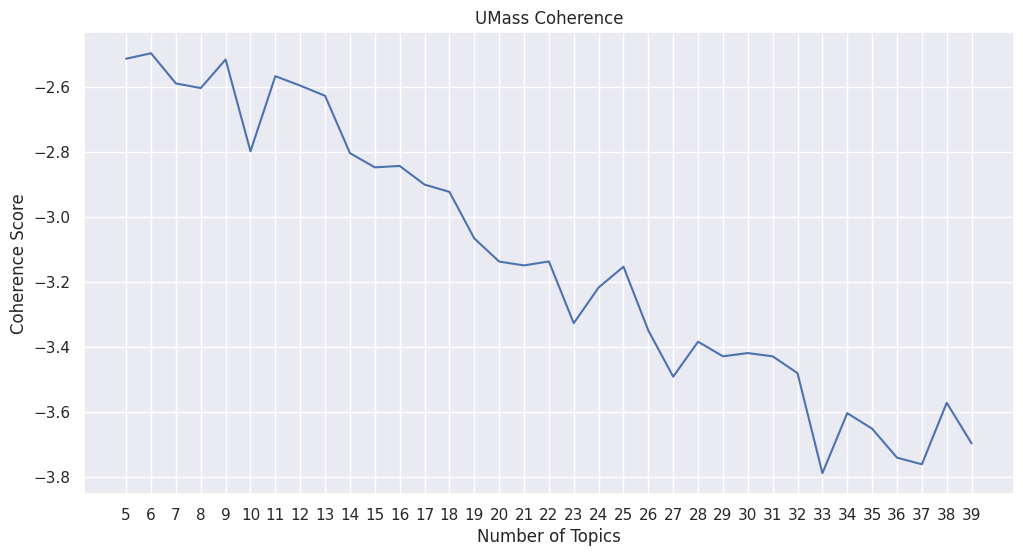

In [15]:
# Calculating the coherence score using C_umass
# for finding the optimal number of topics
topics_c_umass = []
score_c_umass = []

for i in tqdm(range(5,40,1)):
  lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    chunksize=5000,     # controls how many documents are processed at a time
    iterations=10,      # controls how often we repeat a particular loop over each document
    num_topics=i,
    workers = 8,
    passes=10,          # controls how many documents are processed at a time (epochs)
    random_state=100)
  cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
  topics_c_umass.append(i)
  score_c_umass.append(cm.get_coherence())

_=plt.figure(figsize=(12,6))
_=plt.plot(topics_c_umass, score_c_umass)
_=plt.title("UMass Coherence")
_=plt.xticks(np.arange(min(topics_c_umass), max(topics_c_umass)+1, 1.0))
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

100%|██████████| 35/35 [06:39<00:00, 11.42s/it]


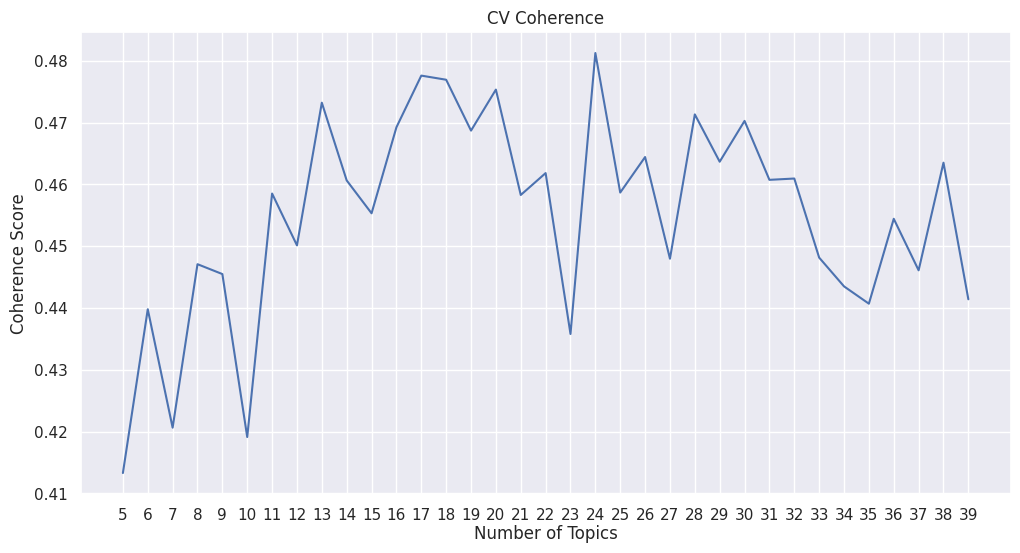

In [16]:
# Calculating the coherence score using C_v
# for finding the optimal number of topics
topics_c_v = []
score_c_v = []

for i in tqdm(range(5,40,1)):
  lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    chunksize=5000,     # controls how many documents are processed at a time
    iterations=10,      # controls how often we repeat a particular loop over each document
    num_topics=i,
    workers = 8,
    passes=10,          # controls how many documents are processed at a time (epochs)
    random_state=100)
  
  cm = CoherenceModel(model=lda_model, texts = propostas['Tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
  topics_c_v.append(i)
  score_c_v.append(cm.get_coherence())

_=plt.figure(figsize=(12,6))
_=plt.plot(topics_c_v, score_c_v)
_=plt.title("CV Coherence")
_=plt.xticks(np.arange(min(topics_c_v), max(topics_c_v)+1, 1.0))
_=plt.xlabel('Number of Topics', labelpad=2)
_=plt.ylabel('Coherence Score')
plt.show()

In [23]:
# Model with optimal number of topics
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=17, workers = 8, passes=100, random_state=100)

## Etapa 5 - Imprimir e visualizar os tópicos

In [24]:
lda_model.print_topics(-1)

[(0,
  '0.055*"pessoa" + 0.030*"renda" + 0.024*"casa" + 0.020*"família" + 0.016*"vida" + 0.016*"baixo" + 0.014*"poder" + 0.014*"governo" + 0.014*"programa" + 0.014*"precisar"'),
 (1,
  '0.048*"mulher" + 0.035*"direito" + 0.025*"violência" + 0.025*"lei" + 0.020*"aposentadoria" + 0.012*"especial" + 0.011*"ano" + 0.010*"ser" + 0.010*"aposentado" + 0.009*"político"'),
 (2,
  '0.027*"digital" + 0.022*"acesso" + 0.021*"tecnologia" + 0.020*"informação" + 0.014*"rede" + 0.014*"comunicação" + 0.013*"nacional" + 0.012*"público" + 0.012*"plataforma" + 0.012*"dado"'),
 (3,
  '0.034*"rural" + 0.023*"familiar" + 0.022*"agricultura" + 0.021*"comunidade" + 0.018*"programa" + 0.017*"campo" + 0.017*"produção" + 0.014*"povo" + 0.013*"urbano" + 0.012*"área"'),
 (4,
  '0.045*"público" + 0.033*"serviço" + 0.020*"recurso" + 0.018*"governo" + 0.017*"empresa" + 0.016*"federal" + 0.012*"moradia" + 0.011*"privado" + 0.011*"ser" + 0.010*"social"'),
 (5,
  '0.034*"transporte" + 0.023*"região" + 0.022*"cidade" + 0.

In [25]:
print(propostas['Texto'][0])
print(lda_model[corpus][0])

turismo: esse é o destino. objetivo: posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.
[(2, 0.20516059), (6, 0.7528152)]


In [26]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [27]:
# Adding topics into the DataFrame
propostas['Topicos'] = [sorted(lda_model[corpus][texto])[0][0] for texto in range(len(propostas['Texto']))]
propostas.head()

,Categoria,Texto,Tokens,Topicos
0,Turismo,"turismo: esse é o destino. objetivo: posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.","[turismo, destino, objetivo, posicionar, turismo, vetor, desenvolvimento, sustentável, aumentar, competitividade, destino, produto, turístico, brasileiro, democratizar, acesso, atividade, turístico, cidadão, brasileiro]",2
1,Desenvolvimento Agrário e Agricultura Familiar,"agricultura familiar e agroecologia. objetivo: fortalecer a agricultura familiar em sua diversidade e a agroecologia, promovendo a inclusão socioeconômica, com fomento à produção sustentável e à geração de renda, contribuindo para a promoção da segurança alimentar e nutricional e da vida digna, com redução das desigualdades e mitigação das mudanças climáticas.","[agricultura, familiar, agroecologia, objetivo, fortalecer, agricultura, familiar, diversidade, agroecologia, promover, inclusão, socioeconômico, fomento, produção, sustentável, geração, renda, contribuir, promoção, segurança, alimentar, nutricional, vida, digna, redução, desigualdade, mitigação, mudança, climático]",3
2,Agricultura e Pecuária,"agropecuária sustentável. objetivo: contribuir para o desenvolvimento do setor agropecuário, com sustentabilidade ambiental, econômica e social, por meio do fomento e da intensificação da produção; da geração, compartilhamento e aplicação de conhecimento técnico-científico; e da regulamentação, certificação, auditoria e fiscalização agropecuária.","[agropecuária, sustentável, objetivo, contribuir, desenvolvimento, setor, agropecuário, sustentabilidade, ambiental, econômico, social, fomento, intensificação, produção, geração, compartilhamento, aplicação, conhecimento, regulamentação, certificação, auditoria, fiscalização, agropecuário]",2
3,Saúde,"atenção primária à saúde. fortalecer a atenção primária à saúde, ampliando a cobertura da estratégia de saúde da família e da saúde bucal, com vistas à universalização do acesso, à abrangência do cuidado integral, à promoção da saúde, à prevenção de agravos e à redução de desigualdades de raça/etnia, de gênero, regionais e sociais","[atenção, primário, saúde, fortalecer, atenção, primário, saúde, ampliar, cobertura, estratégia, saúde, família, saúde, bucal, vista, universalização, acesso, abrangência, cuidado, integral, promoção, saúde, prevenção, agravo, redução, desigualdade, raça, etnia, gênero, regional, social]",16
4,Saúde,"atenção especializada à saúde. ampliar o acesso às ações e serviços da atenção especializada à saúde, conforme as necessidades de saúde da população, reduzindo as desigualdades de raça/etnia, de gênero, regionais e sociais, e promovendo a integralidade do cuidado","[atenção, especializar, saúde, ampliar, acesso, ação, serviço, atenção, especializar, saúde, conforme, necessidade, saúde, população, reduzir, desigualdade, raça, etnia, gênero, regional, social, promover, integralidade, cuidado]",16


In [28]:
# Counting the frequency of each topic
propostas.Topicos.value_counts()

Topicos
0     2950
1     1615
2     1376
3      916
4      757
7      719
5      695
6      323
10     314
9      247
12     219
8      186
11     121
13     115
14     114
16      37
15      19
Name: count, dtype: int64